# 2022/01/27 Model Validation & Visualization

#### Aim
Visualize model structure & validation scores of the experiment on `20220120-training-2.py`

### Get & Add the path

In [1]:
import pathlib
import sys

from pathlib import Path


current_dir: Path = pathlib.Path().cwd().resolve()
task1and2_dir: Path = current_dir.parent
project_root: Path = current_dir.parent.parent
data_dir: Path = task1and2_dir / "data" / "train"

sys.path.append(str(task1and2_dir))
sys.path.append(str(project_root))


### Get & Visualize trained `TaskChallenger3`

In [2]:
import torchinfo
import torch

from corsmal_challenge.models.task1_2 import TaskChallenger3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batches = 1
in_channels = 8
seq_len = 1000
embed_dim = 128

dummy_spectrogram = torch.zeros(batches, in_channels, seq_len, embed_dim)
model = TaskChallenger3()
model.load_state_dict(torch.load(current_dir / "20220120-training-2-result.pt"))
for param in model.parameters():
    param.requires_grad = False

dummy_spectrogram = dummy_spectrogram.to(device)
model = model.to(device)

In [3]:
print("\nTaskChallenger3.encoder")
print(torchinfo.summary(model.encoder, inputs_size=dummy_spectrogram.shape))


TaskChallenger3.encoder
Layer (type:depth-idx)                                  Param #
LogMelEncoder                                           --
├─BatchNorm2d: 1-1                                      (16)
├─DepthWiseConv2d: 1-2                                  (416)
├─PointWiseConv2d: 1-3                                  (17)
├─TransformerEncoder: 1-4                               --
│    └─CLSTokenAdder: 2-1                               --
│    │    └─Linear: 3-1                                 (128)
│    └─PositionalEncoding: 2-2                          --
│    └─TransformerEncoderBlock: 2-3                     --
│    │    └─LayerNorm: 3-2                              (256)
│    │    └─MultiheadedSelfAttention: 3-3               (66,048)
│    │    └─FFN: 3-4                                    (65,920)
│    └─Sequential: 2-4                                  --
│    │    └─TransformerEncoderBlock: 3-5                (132,224)
│    │    └─TransformerEncoderBlock: 3-6             

In [4]:

print("\nTaskChallenger3.classify_head1")
print(torchinfo.summary(model.classify_head1, inputs_size=dummy_spectrogram.shape))


TaskChallenger3.classify_head1
Layer (type:depth-idx)                   Param #
T1Head                                   --
├─Linear: 1-1                            (4,128)
├─Linear: 1-2                            (99)
Total params: 4,227
Trainable params: 0
Non-trainable params: 4,227


In [5]:

print("\nTaskChallenger3.classify_head2")
print(torchinfo.summary(model.classify_head2, inputs_size=dummy_spectrogram.shape))


TaskChallenger3.classify_head2
Layer (type:depth-idx)                   Param #
T2Head                                   --
├─Linear: 1-1                            (4,128)
├─Linear: 1-2                            (132)
Total params: 4,260
Trainable params: 0
Non-trainable params: 4,260


## Validation

In [6]:
from corsmal_challenge.utils import fix_random_seeds

RAND_SEED = 0


# fix random seeds
fix_random_seeds(RAND_SEED)


#### Reproduce Dataset used in the experiment on `20220120-training-2.py`

In [7]:
import json
from typing import Dict, List

from corsmal_challenge.data.dataset import AudioDataset
from corsmal_challenge.data.data_loader import ReproducibleDataLoader as DataLoader


# get annotations
with open(str(data_dir / "ccm_train_annotation.json"), "r") as f:
    dic = json.load(f)
    annotations: List[Dict] = dic["annotations"]
    containers: List[Dict] = dic["containers"]

# use same validation dataset (picked from `20220120-training-2.py`)
mv_val2train = 50
validation_dataset = AudioDataset(
    data_dir,
    data_dir / "ccm_train_annotation.json",
    seed=RAND_SEED,
    mv_val2train=mv_val2train,
    train=False,
    return_also_data_id=True,
)
val_dataloader = DataLoader(validation_dataset, specified_seed=RAND_SEED)


In [8]:
lis = [annotations[data_id]["filling type"] for _, _, data_id in val_dataloader]
print(lis.count(0))
print(lis.count(1))
print(lis.count(2))
print(lis.count(3))

20
40
18
0


### Collect Validation Results

In [9]:
from typing import Optional


class EstimationData:
    def __init__(
        self,
        data_id: Optional[int] = None,
        container_id: Optional[int] = None,
        task1_label: Optional[int] = None,
        task1_pred: Optional[int] = None,
        task1_process_time: Optional[float] = None,
        task2_label: Optional[int] = None,
        task2_pred: Optional[int] = None,
        task2_process_time: Optional[float] = None,
    ):
        self.data_id = data_id
        self.container_id = container_id
        self.task1_label = task1_label
        self.task1_pred = task1_pred
        self.task1_process_time = task1_process_time
        self.task2_label = task2_label
        self.task2_pred = task2_pred
        self.task2_process_time = task2_process_time


In [10]:
result_dict: Dict[int, EstimationData] = {
    int(data_id): EstimationData(
        int(data_id),
        annotations[data_id]["container id"],
    )
    for _, _, data_id in val_dataloader
}


task1 (level estimation)

In [11]:
import time


validation_dataset.query = "level"
model.task_id = 1
with torch.no_grad():
    for val_data, label, data_id in val_dataloader:
        d_id = int(data_id)
        # data transport
        if device != torch.device("cpu"):
            val_data = val_data.to(device, non_blocking=True)
            label = label.to(device, non_blocking=True)
        start_time = time.process_time()
        pred = model(val_data).argmax(dim=1)
        process_time = time.process_time() - start_time
        result_dict[d_id].task1_label = int(label)
        result_dict[d_id].task1_pred = int(pred)
        result_dict[d_id].task1_process_time = process_time


task2 (type estimation)

In [12]:
validation_dataset.query = "type"
model.task_id = 2
with torch.no_grad():
    for val_data, label, data_id in val_dataloader:
        d_id = int(data_id)
        # data transport
        if device != torch.device("cpu"):
            val_data = val_data.to(device, non_blocking=True)
            label = label.to(device, non_blocking=True)
        start_time = time.process_time()
        pred = model(val_data).argmax(dim=1)
        process_time = time.process_time() - start_time
        result_dict[d_id].task2_label = int(label)
        result_dict[d_id].task2_pred = int(pred)
        result_dict[d_id].task2_process_time = process_time


### Create confusion matrices

#### For entire validation dataset

Task1: Accuracy=0.9102564102564102
       empty F1=0.974
       half  F1=0.907
       full  F1=0.857
Task2: Accuracy=0.9871794871794872
       none  F1=0.974
       pasta F1=1.000
       rice  F1=1.000
       water F1=0.000


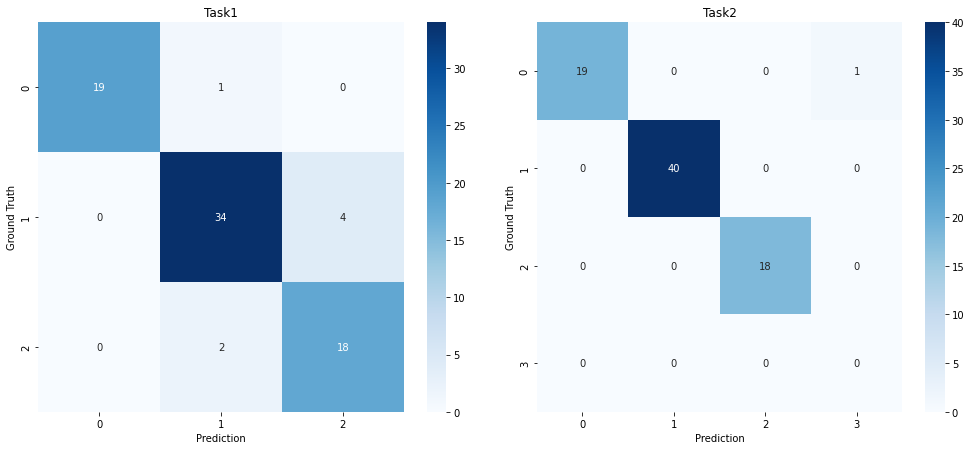

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

rows = 1
cols = 2
square_size = 6
fig, subplot_axis = plt.subplots(nrows=rows, ncols=cols, figsize=((square_size + 1) * cols, square_size * rows))
fig.tight_layout()
fig.patch.set_facecolor('#fff')

task_labels = [result.task1_label for result in result_dict.values()]
task_preds = [result.task1_pred for result in result_dict.values()]
cm = confusion_matrix(task_labels, task_preds)  # [label, pred]
acc_score = accuracy_score(task_labels, task_preds)
f1 = f1_score(task_labels, task_preds, average=None)
print(f"Task1: Accuracy={acc_score}")
print(f"       empty F1={f1[0]:.3f}")
print(f"       half  F1={f1[1]:.3f}")
print(f"       full  F1={f1[2]:.3f}")
sns.heatmap(cm, annot=True, cmap="Blues", ax=subplot_axis[0])

task_labels = [result.task2_label for result in result_dict.values()]
task_preds = [result.task2_pred for result in result_dict.values()]
cm = confusion_matrix(task_labels, task_preds) # [label, pred]
acc_score = accuracy_score(task_labels, task_preds)
f1 = f1_score(task_labels, task_preds, average=None)
print(f"Task2: Accuracy={acc_score}")
print(f"       none  F1={f1[0]:.3f}")
print(f"       pasta F1={f1[1]:.3f}")
print(f"       rice  F1={f1[2]:.3f}")
if len(f1) >= 4:
    print(f"       water F1={f1[3]:.3f}")
sns.heatmap(cm, annot=True, cmap="Blues", ax=subplot_axis[1])

subplot_axis[0].title.set_text("Task1")
subplot_axis[1].title.set_text("Task2")

for ax in subplot_axis:
    ax.set_ylabel("Ground Truth")
    ax.set_xlabel("Prediction")

plt.show()


#### For each container type


Container type: cup
Task1: Accuracy=0.9047619047619048
       empty F1=1.000
       half  F1=0.909
       full  F1=0.800
Task2: Accuracy=1.0
       none  F1=1.000
       pasta F1=1.000
       rice  F1=1.000

Container type: drinking glass
Task1: Accuracy=0.9375
       empty F1=1.000
       half  F1=0.933
       full  F1=0.875
Task2: Accuracy=1.0
       none  F1=1.000
       pasta F1=1.000
       rice  F1=1.000

Container type: food box
Task1: Accuracy=0.88
       empty F1=0.909
       half  F1=0.870
       full  F1=0.875
Task2: Accuracy=0.96
       none  F1=0.909
       pasta F1=1.000
       rice  F1=1.000
       water F1=0.000


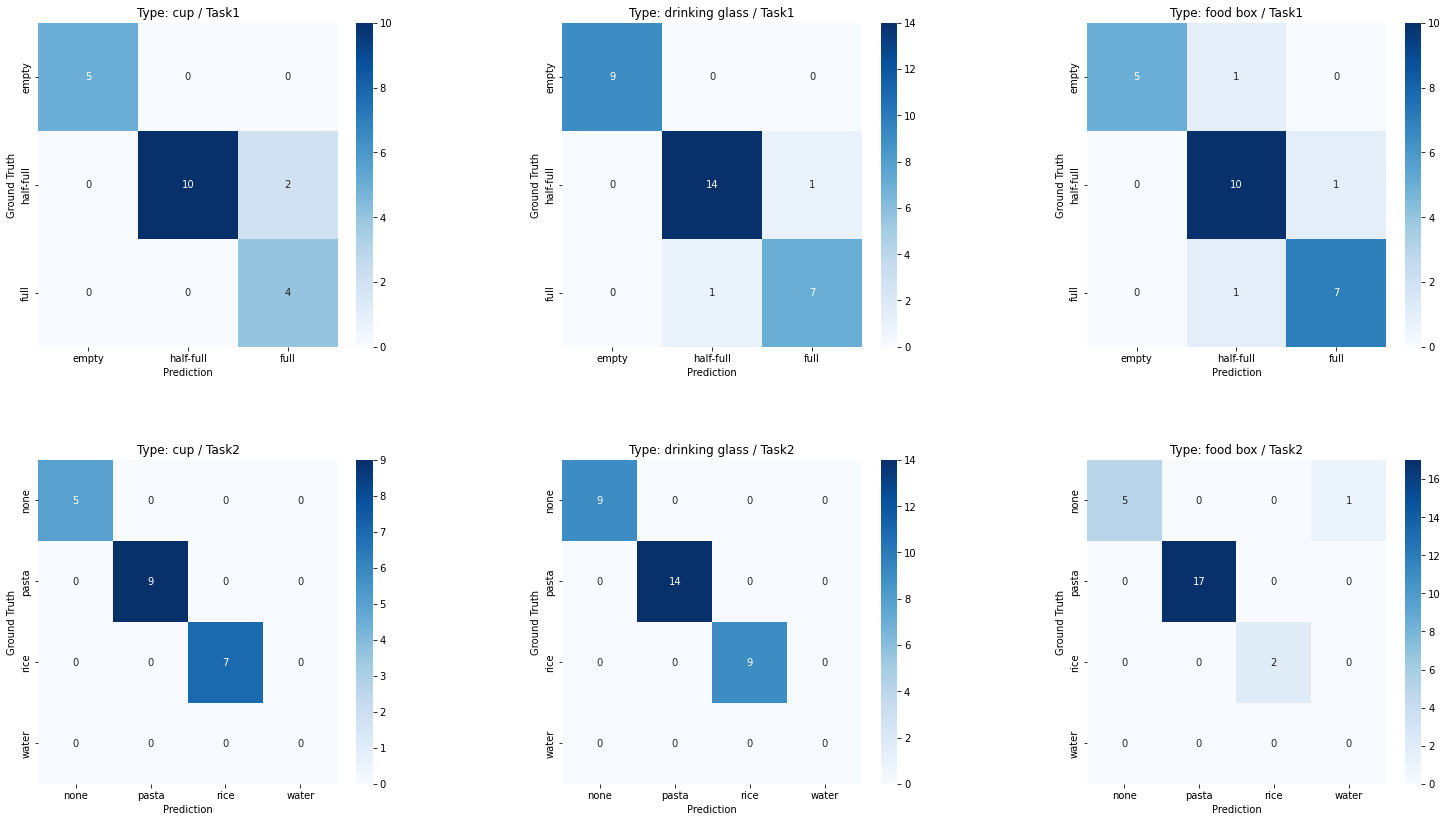

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


rows = 2
cols = 3
square_size = 7
wspc = 0.4
hspc = 0.35
fig, subplot_axis = plt.subplots(
    nrows=rows, ncols=cols, figsize=((square_size + 1 + 10 * (wspc - hspc)) * cols, square_size * rows)
)
fig.patch.set_facecolor("#fff")

container_types = ["cup", "drinking glass", "food box"]
filling_types = ["none", "pasta", "rice", "water"]
filling_levels = ["empty", "half-full", "full"]

for i, typ in enumerate(container_types):
    print(f"\nContainer type: {typ}")
    task_labels = [
        result.task1_label for result in result_dict.values() if containers[result.container_id - 1]["type"] == typ
    ]
    task_preds = [
        result.task1_pred for result in result_dict.values() if containers[result.container_id - 1]["type"] == typ
    ]
    cm = confusion_matrix(task_labels, task_preds, labels=[0,1,2])
    acc_score = accuracy_score(task_labels, task_preds)
    f1 = f1_score(task_labels, task_preds, average=None)
    print(f"Task1: Accuracy={acc_score}")
    print(f"       empty F1={f1[0]:.3f}")
    print(f"       half  F1={f1[1]:.3f}")
    print(f"       full  F1={f1[2]:.3f}")
    sns.heatmap(cm, annot=True, cmap="Blues", ax=subplot_axis[0, i])

    task_labels = [
        result.task2_label for result in result_dict.values() if containers[result.container_id - 1]["type"] == typ
    ]
    task_preds = [
        result.task2_pred for result in result_dict.values() if containers[result.container_id - 1]["type"] == typ
    ]
    cm = confusion_matrix(task_labels, task_preds, labels=[0,1,2,3])
    acc_score = accuracy_score(task_labels, task_preds)
    f1 = f1_score(task_labels, task_preds, average=None)
    print(f"Task2: Accuracy={acc_score}")
    print(f"       none  F1={f1[0]:.3f}")
    print(f"       pasta F1={f1[1]:.3f}")
    print(f"       rice  F1={f1[2]:.3f}")
    if len(f1) >= 4:
        print(f"       water F1={f1[3]:.3f}")
    sns.heatmap(cm, annot=True, cmap="Blues", ax=subplot_axis[1, i])

    subplot_axis[0, i].title.set_text(f"Type: {typ} / Task1")
    subplot_axis[1, i].title.set_text(f"Type: {typ} / Task2")
    subplot_axis[0, i].set_xticklabels(filling_levels)
    subplot_axis[0, i].set_yticklabels(filling_levels)
    subplot_axis[1, i].set_xticklabels(filling_types)
    subplot_axis[1, i].set_yticklabels(filling_types)

for axs in subplot_axis:
    for ax in axs:
        ax.set_ylabel("Ground Truth")
        ax.set_xlabel("Prediction")


plt.subplots_adjust(wspace=wspc, hspace=hspc)
plt.show()


#### for each container


Container type: red cup
Task1: Accuracy=1.0
       Macro-F1=1.0
       Processing time: 0.003 sec
Task2: Accuracy=1.0
       Macro-F1=1.0
       Processing time: 0.002 sec

Container type: small white cup
Task1: Accuracy=0.5
       Macro-F1=0.5
       Processing time: 0.003 sec
Task2: Accuracy=1.0
       Macro-F1=1.0
       Processing time: 0.003 sec

Container type: small transparent cup
Task1: Accuracy=1.0
       Macro-F1=1.0
       Processing time: 0.002 sec
Task2: Accuracy=1.0
       Macro-F1=1.0
       Processing time: 0.003 sec

Container type: green glass
Task1: Accuracy=0.8571428571428571
       Macro-F1=0.8571428571428571
       Processing time: 0.003 sec
Task2: Accuracy=1.0
       Macro-F1=1.0
       Processing time: 0.002 sec

Container type: wine glass
Task1: Accuracy=1.0
       Macro-F1=1.0
       Processing time: 0.002 sec
Task2: Accuracy=1.0
       Macro-F1=1.0
       Processing time: 0.003 sec

Container type: champagne flute
Task1: Accuracy=0.9230769230769231
       M

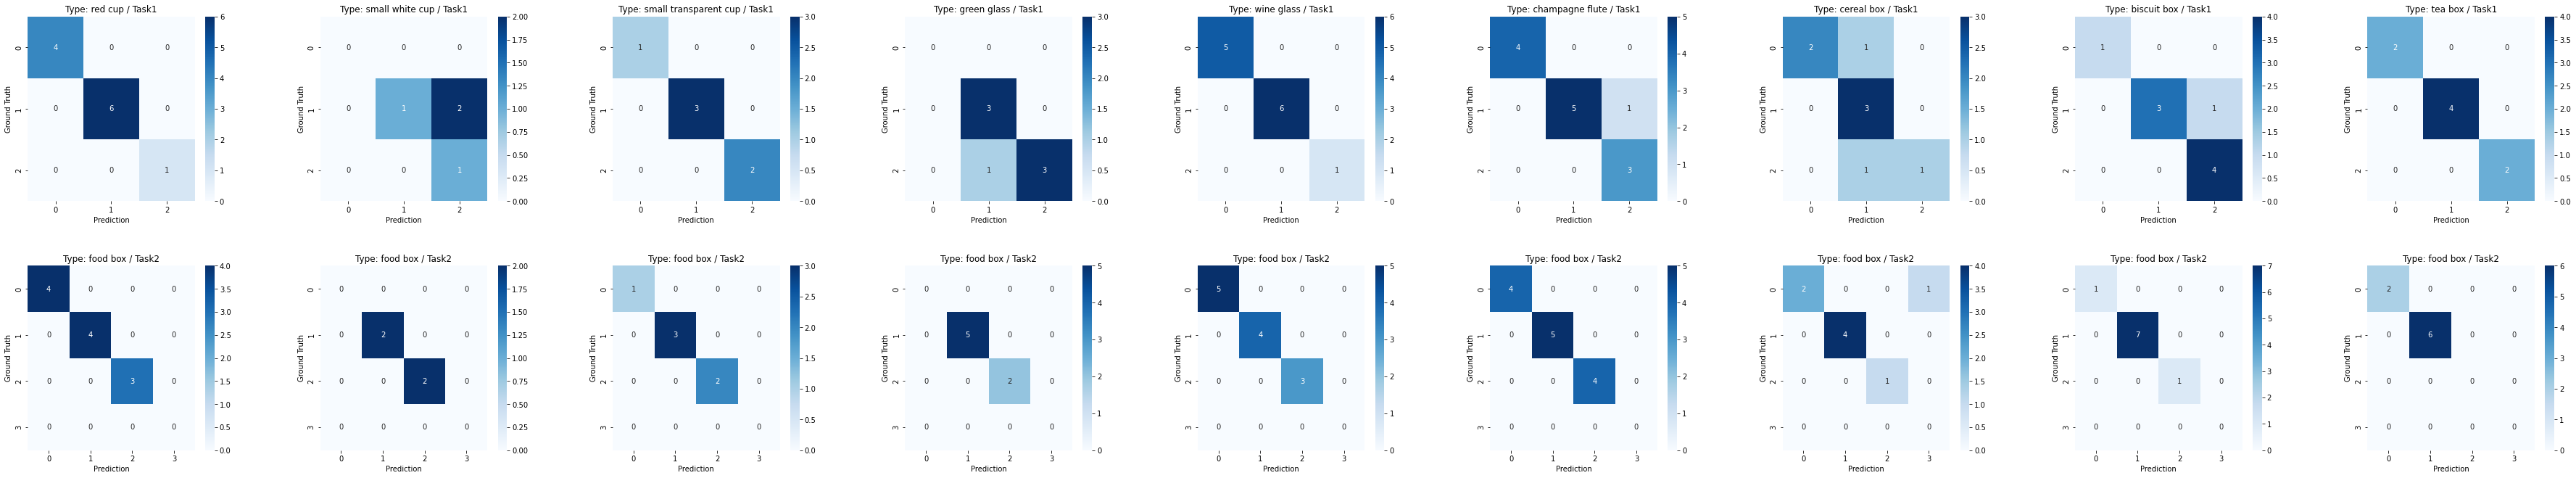

In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


rows = 2
cols = 9
square_size = 5.5
wspc = 0.4
hspc = 0.35
fig, subplot_axis = plt.subplots(
    nrows=rows, ncols=cols, figsize=((square_size + 1 + 10 * (wspc - hspc)) * cols, square_size * rows)
)
fig.patch.set_facecolor("#fff")

container_names = [c["name"] for c in containers]

for i, nam in enumerate(container_names):
    print(f"\nContainer type: {nam}")
    task_labels = [
        result.task1_label for result in result_dict.values() if containers[result.container_id - 1]["name"] == nam
    ]
    task_preds = [
        result.task1_pred for result in result_dict.values() if containers[result.container_id - 1]["name"] == nam
    ]
    cm = confusion_matrix(task_labels, task_preds, labels=[0, 1, 2])
    acc_score = accuracy_score(task_labels, task_preds)
    f1 = f1_score(task_labels, task_preds, average="macro")
    print(f"Task1: Accuracy={acc_score}")
    print(f"       Macro-F1={f1}")
    p_time1 = np.average(
        [
            result.task1_process_time
            for result in result_dict.values()
            if containers[result.container_id - 1]["name"] == nam
        ]
    )
    print(f"       Processing time: {p_time1:.3f} sec")
    sns.heatmap(cm, annot=True, cmap="Blues", ax=subplot_axis[0, i])

    task_labels = [
        result.task2_label for result in result_dict.values() if containers[result.container_id - 1]["name"] == nam
    ]
    task_preds = [
        result.task2_pred for result in result_dict.values() if containers[result.container_id - 1]["name"] == nam
    ]
    cm = confusion_matrix(task_labels, task_preds, labels=[0, 1, 2, 3])
    acc_score = accuracy_score(task_labels, task_preds)
    f1 = f1_score(task_labels, task_preds, average="macro")
    print(f"Task2: Accuracy={acc_score}")
    print(f"       Macro-F1={f1}")
    p_time2 = np.average(
        [
            result.task2_process_time
            for result in result_dict.values()
            if containers[result.container_id - 1]["name"] == nam
        ]
    )
    print(f"       Processing time: {p_time2:.3f} sec")
    sns.heatmap(cm, annot=True, cmap="Blues", ax=subplot_axis[1, i])

    subplot_axis[0, i].title.set_text(f"Type: {nam} / Task1")
    subplot_axis[1, i].title.set_text(f"Type: {typ} / Task2")

for axs in subplot_axis:
    for ax in axs:
        ax.set_ylabel("Ground Truth")
        ax.set_xlabel("Prediction")


plt.subplots_adjust(wspace=wspc, hspace=hspc)
plt.show()
